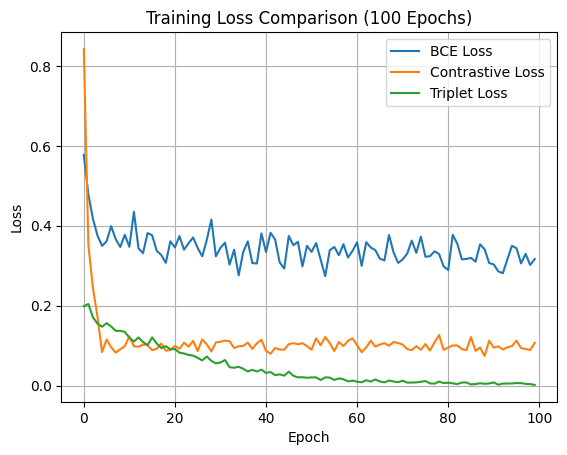

In [3]:
# 📌 STEP 1: Imports & Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 📌 STEP 2: Dataset (Pairwise & Triplet)
class FacePairDataset(Dataset):
    def __init__(self, num_samples=500, embedding_dim=128, triplet=False):
        self.triplet = triplet
        self.embeddings = torch.randn(num_samples, embedding_dim)
        self.labels = torch.randint(0, 10, (num_samples,))

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        if self.triplet:
            anchor = self.embeddings[idx]
            anchor_label = self.labels[idx]
            pos_idx = (self.labels == anchor_label).nonzero().flatten()
            neg_idx = (self.labels != anchor_label).nonzero().flatten()
            pos = self.embeddings[random.choice(pos_idx)]
            neg = self.embeddings[random.choice(neg_idx)]
            return anchor, pos, neg
        else:
            emb1 = self.embeddings[idx]
            label1 = self.labels[idx]
            j = random.choice(range(len(self.embeddings)))
            emb2 = self.embeddings[j]
            label2 = self.labels[j]
            is_same = torch.tensor([1.0]) if label1 == label2 else torch.tensor([0.0])
            return emb1, emb2, is_same

# 📌 STEP 3: Models
class EmbeddingNet(nn.Module):
    def __init__(self, in_dim=128, out_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    def forward(self, x):
        return self.fc(x)

class BCEVerifier(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, emb1, emb2):
        return self.fc(torch.cat([emb1, emb2], dim=1))

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, f1, f2, label):
        dist = F.pairwise_distance(f1, f2)
        loss = label * dist.pow(2) + (1 - label) * F.relu(self.margin - dist).pow(2)
        return loss.mean()

# 📌 STEP 4: Training Loop
def train_bce():
    model = BCEVerifier()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    loader = DataLoader(FacePairDataset(), batch_size=32, shuffle=True)
    losses = []
    for epoch in range(100):
        epoch_loss = 0
        for emb1, emb2, label in loader:
            pred = model(emb1, emb2)
            loss = criterion(pred, label.view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(loader))
    return losses

def train_contrastive():
    model = EmbeddingNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = ContrastiveLoss()
    loader = DataLoader(FacePairDataset(), batch_size=32, shuffle=True)
    losses = []
    for epoch in range(100):
        epoch_loss = 0
        for emb1, emb2, label in loader:
            f1 = model(emb1)
            f2 = model(emb2)
            loss = criterion(f1, f2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(loader))
    return losses

def train_triplet():
    model = EmbeddingNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.TripletMarginLoss(margin=0.02)
    loader = DataLoader(FacePairDataset(triplet=True), batch_size=32, shuffle=True)
    losses = []
    for epoch in range(100):
        epoch_loss = 0
        for a, p, n in loader:
            anchor = model(a)
            pos = model(p)
            neg = model(n)
            loss = criterion(anchor, pos, neg)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(loader))
    return losses

# 📌 STEP 5: Run all and plot
bce_losses = train_bce()
contrastive_losses = train_contrastive()
triplet_losses = train_triplet()

plt.plot(bce_losses, label="BCE Loss")
plt.plot(contrastive_losses, label="Contrastive Loss")
plt.plot(triplet_losses, label="Triplet Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (100 Epochs)")
plt.legend()
plt.grid(True)
plt.show()
